# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter

pd.options.mode.chained_assignment = None  # default='warn

### Read data into one big dictionary

In [2]:
os.chdir("./data")
study_data_names = [file for file in glob.glob("*.csv")]
os.chdir("..")
data = {0:{}, 1:{}}
for file in study_data_names:
    if(file.startswith('0')):
        group = 0
        index_questionnaire_end = 27
    else:
        group = 1
        index_questionnaire_end = 29
    data[group][file] = {}
    df = pd.read_csv("./data/" + file, quotechar="\"", names = ["question", "answer1", "answer2", "answer3"])
    if df.shape[0] == 10:
        df_songs = df
        df_songs["correct"] = ["WINNER" if s == "False" else "LOSER" for s in df_songs["answer1"]]
        df_songs.columns = ["song", "is_last", "human", "with_ai", "correct"]
        data[group][file]["songs"] = df_songs
    else:
        df_songs = df.loc[0:9]
        df_songs["correct"] = ["WINNER" if s == "False" else "LOSER" for s in df_songs["answer1"]]
        df_songs.columns = ["song", "is_last", "human", "with_ai", "correct"]
        data[group][file]["songs"] = df_songs
        df_quests = df.loc[10:index_questionnaire_end][["question","answer1","answer2"]]
        df_quests.columns = ["question", "answer","detail"]
        data[group][file]["questionnaire"] = df_quests
        times = df[index_questionnaire_end+1:].values[0][:3]
        times = [float(t.strip()) for t in times]
        diff_times = [times[1]-times[0], times[2]-times[1]]
        data[group][file]["times"] = diff_times

### Calculate extra info

In [3]:
def count_switches(df_songs):
    try:
        correct = df_songs[df_songs["human"]==df_songs["correct"]]
        c_correct = correct.shape[0]
        c_mislead = int(c_correct/2)
        mislead_switch = correct[correct["human"] != correct["with_ai"]]
        c_mislead_switch = mislead_switch.shape[0]
        incorrect = df_songs[df_songs["human"]!=df_songs["correct"]]
        c_incorrect = incorrect.shape[0]
        assert c_correct+c_incorrect == 10
        c_help = 5-(c_correct-c_mislead)
        help_switch = incorrect[incorrect["human"] != incorrect["with_ai"]]
        c_help_switch = help_switch.shape[0]
        c_correct_ai = df_songs[df_songs["with_ai"]==df_songs["correct"]].shape[0]
        return({"num_correct":c_correct, "num_correct_ai":c_correct_ai, "num_mislead":c_mislead, "num_mislead_switch":c_mislead_switch, "num_incorrect":c_incorrect, "num_help":c_help, "num_help_switch":c_help_switch, "num_total_disagree":c_mislead+c_help, "num_total_switch":c_mislead_switch+c_help_switch})
    except:
        print(df_songs)
        return False

In [4]:
for group in [0, 1]:
    for file in data[group]:
        counts = count_switches(data[group][file]["songs"])
        data[group][file]["switch_count"] = counts

In [5]:
data[0]["0_40.csv"]

{'songs':   song is_last   human with_ai correct
 0  649   False  WINNER  WINNER  WINNER
 1  744    True   LOSER   LOSER   LOSER
 2  400    True   LOSER   LOSER   LOSER
 3  382   False   LOSER   LOSER  WINNER
 4  768    True  WINNER  WINNER   LOSER
 5  438    True  WINNER  WINNER   LOSER
 6  626   False  WINNER  WINNER  WINNER
 7  421   False   LOSER   LOSER  WINNER
 8  362    True   LOSER   LOSER   LOSER
 9  325   False   LOSER   LOSER  WINNER,
 'questionnaire':    question             answer                      detail
 10        1           UNLIKELY                         NaN
 11        2              NEVER                         NaN
 12        3                 NO                            
 13        4                YES   The internet... Chat GPT 
 14        5                 28                         NaN
 15        6               MALE                         NaN
 16    rel_5              AGREE                         NaN
 17    rel_1           DISAGREE                      

### Reformat into one table

In [6]:
data_analysis = []
likert_lookup = {"STRONGLY AGREE":2, "AGREE":1, "NEUTRAL":0, "DISAGREE":-1, "STRONGLY DISAGREE":-2}
for group in [0, 1]:
    for file in data[group]:

        participant = {}
        participant["group"] = group
        participant["file"] = file
        filenum = int(file.split("_")[1].replace(".csv",""))
        participant["filenum"] = filenum

        if "times" in data[group][file]:
            participant["questionnaire"] = True
            if (group == 0 and filenum > 22) or (group == 1 and filenum > 23):
                participant["trust_questionnaire"] = True
            else:
                participant["trust_questionnaire"] = False
            participant["time_alone"] = data[group][file]["times"][0]
            participant["time_ai"] = data[group][file]["times"][1]
            participant["time_total"] = data[group][file]["times"][0] + data[group][file]["times"][1]

            quest_results = data[group][file]["questionnaire"].set_index("question")
            participant["AI_successful"] = (["VERY LIKELY", "LIKELY", "NEUTRAL", "UNLIKELY", "VERY UNLIKELY"].index(quest_results.loc["1"]["answer"])-2)*(-1)
            participant["euro_watcher"] = (["EVERY YEAR", "MOST YEARS", "SOMETIMES", "RARELY", "NEVER"].index(quest_results.loc["2"]["answer"])-2)*(-1)
            participant["song_knowledge"] = quest_results.loc["3"]["answer"]
            participant["song_knowledge_which"] = quest_results.loc["3"]["detail"]
            participant["AI_knowledge"] = quest_results.loc["4"]["answer"]
            participant["AI_knowledge_what"] = quest_results.loc["4"]["detail"]
            participant["age"] = quest_results.loc["5"]["answer"]
            participant["gender"] = quest_results.loc["6"]["answer"]
            participant["rel_1"] = likert_lookup[quest_results.loc["rel_1"]["answer"]]
            participant["rel_2"] = likert_lookup[quest_results.loc["rel_2"]["answer"]]
            participant["rel_5"] = likert_lookup[quest_results.loc["rel_5"]["answer"]]
            participant["com_1"] = likert_lookup[quest_results.loc["com_1"]["answer"]]
            participant["com_2"] = likert_lookup[quest_results.loc["com_2"]["answer"]]
            participant["com_3"] = likert_lookup[quest_results.loc["com_3"]["answer"]]
            participant["com_5"] = likert_lookup[quest_results.loc["com_5"]["answer"]]
            participant["fai_1"] = likert_lookup[quest_results.loc["fai_1"]["answer"]]
            participant["fai_2"] = likert_lookup[quest_results.loc["fai_2"]["answer"]]
            participant["fai_3"] = likert_lookup[quest_results.loc["fai_3"]["answer"]]
            participant["fai_4"] = likert_lookup[quest_results.loc["fai_4"]["answer"]]
            participant["fai_5"] = likert_lookup[quest_results.loc["fai_5"]["answer"]]
            participant["rel"] = (participant["rel_1"] + participant["rel_2"] + participant["rel_5"])/3
            participant["com"] = (participant["com_1"] + participant["com_2"] + participant["com_3"] + participant["com_3"])/4
            participant["fai"] = (participant["fai_1"] + participant["fai_2"] + participant["fai_3"] + participant["fai_4"] + participant["fai_5"])/5
            participant["trust"] = (participant["rel_1"] + participant["rel_2"] + participant["rel_5"] + participant["com_1"] + participant["com_2"] + participant["com_3"] + participant["com_3"] + participant["fai_1"] + participant["fai_2"] + participant["fai_3"] + participant["fai_4"] + participant["fai_5"])/12
            
            if "7" in quest_results.index:
                participant["AI_answer_basis"] = quest_results.loc["7"]["answer"]
                participant["AI_plausibility"] = quest_results.loc["8"]["answer"]
            else:
                participant["AI_answer_basis"] = ""
                participant["AI_plausibility"] = ""

        else:
            participant["questionnaire"] = False
            participant["trust_questionnaire"] = False

        for key in data[group][file]["switch_count"]:
            participant[key] = data[group][file]["switch_count"][key]
        participant["ratio_switch"] = participant["num_total_switch"]/participant["num_total_disagree"]
        if participant["num_help"]:
            participant["ratio_help"] = participant["num_help_switch"]/participant["num_help"]
        participant["ratio_mislead"] = participant["num_mislead_switch"]/participant["num_mislead"]

        data_analysis.append(participant)

df_data = pd.DataFrame(data_analysis)

In [7]:
df_data[["file",'num_correct', 'num_correct_ai',
  'num_mislead',
  'num_mislead_switch',
  'num_incorrect',
  'num_help',
  'num_help_switch',
  'num_total_disagree',
  'num_total_switch',"ratio_switch", "ratio_mislead", "ratio_help"]]

,file,num_correct,num_correct_ai,num_mislead,num_mislead_switch,num_incorrect,num_help,num_help_switch,num_total_disagree,num_total_switch,ratio_switch,ratio_mislead,ratio_help
0,0_0.csv,6,6,3,0,4,2,0,5,0,0.0,0.000000,0.0
1,0_1.csv,4,4,2,0,6,3,0,5,0,0.0,0.000000,0.0
2,0_10.csv,6,6,3,1,4,2,1,5,2,0.4,0.333333,0.5
3,0_11.csv,3,3,1,0,7,3,0,4,0,0.0,0.000000,0.0
4,0_12.csv,9,9,4,0,1,0,0,4,0,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1_5.csv,8,8,4,0,2,1,0,5,0,0.0,0.000000,0.0
77,1_6.csv,8,8,4,0,2,1,0,5,0,0.0,0.000000,0.0
78,1_7.csv,4,4,2,0,6,3,0,5,0,0.0,0.000000,0.0
79,1_8.csv,7,7,3,0,3,1,0,4,0,0.0,0.000000,0.0


In [8]:
df_data

,group,file,filenum,questionnaire,trust_questionnaire,time_alone,time_ai,time_total,AI_successful,euro_watcher,...,num_mislead,num_mislead_switch,num_incorrect,num_help,num_help_switch,num_total_disagree,num_total_switch,ratio_switch,ratio_help,ratio_mislead
0,0,0_0.csv,0,True,False,56.435961,108.015340,164.451300,-1.0,2.0,...,3,0,4,2,0,5,0,0.0,0.0,0.000000
1,0,0_1.csv,1,False,False,NaN,NaN,NaN,NaN,NaN,...,2,0,6,3,0,5,0,0.0,0.0,0.000000
2,0,0_10.csv,10,True,False,152.498775,267.397878,419.896653,0.0,1.0,...,3,1,4,2,1,5,2,0.4,0.5,0.333333
3,0,0_11.csv,11,False,False,NaN,NaN,NaN,NaN,NaN,...,1,0,7,3,0,4,0,0.0,0.0,0.000000
4,0,0_12.csv,12,True,False,42.308878,296.677510,338.986388,1.0,2.0,...,4,0,1,0,0,4,0,0.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1,1_5.csv,5,True,False,490.455578,379.173725,869.629302,-1.0,2.0,...,4,0,2,1,0,5,0,0.0,0.0,0.000000
77,1,1_6.csv,6,True,False,215.980422,136.529978,352.510399,0.0,0.0,...,4,0,2,1,0,5,0,0.0,0.0,0.000000
78,1,1_7.csv,7,False,False,NaN,NaN,NaN,NaN,NaN,...,2,0,6,3,0,5,0,0.0,0.0,0.000000
79,1,1_8.csv,8,True,False,70.825543,107.343128,178.168671,1.0,1.0,...,3,0,3,1,0,4,0,0.0,0.0,0.000000


In [9]:
df_data.columns

Index(['group', 'file', 'filenum', 'questionnaire', 'trust_questionnaire',
       'time_alone', 'time_ai', 'time_total', 'AI_successful', 'euro_watcher',
       'song_knowledge', 'song_knowledge_which', 'AI_knowledge',
       'AI_knowledge_what', 'age', 'gender', 'rel_1', 'rel_2', 'rel_5',
       'com_1', 'com_2', 'com_3', 'com_5', 'fai_1', 'fai_2', 'fai_3', 'fai_4',
       'fai_5', 'rel', 'com', 'fai', 'trust', 'AI_answer_basis',
       'AI_plausibility', 'num_correct', 'num_correct_ai', 'num_mislead',
       'num_mislead_switch', 'num_incorrect', 'num_help', 'num_help_switch',
       'num_total_disagree', 'num_total_switch', 'ratio_switch', 'ratio_help',
       'ratio_mislead'],
      dtype='object')

# Analysis and Visualization 

### Functions

In [20]:
def compare(columns, df0 = df_0, df1 = df_1):
    for c in columns:
        print(c, "\n")
        print("All")
        print("Mean:", np.nanmean(list(df0[c])+list(df1[c])))
        print("Std:", np.std(list(df0[c])+list(df1[c])))
        print("Min & Max:", min(list(df0[c])+list(df1[c])), max(list(df0[c])+list(df1[c])))
        print("\n")
        print("Group 0")
        print("Mean:", np.nanmean(df0[c]))
        print("Std:", np.std(df0[c]))
        print("Min & Max:", min(df0[c]), max(df0[c]))
        print("\n")
        print("Group 1")
        print("Mean:", np.nanmean(df1[c]))
        print("Std:", np.std(df1[c]))
        print("Min & Max:", min(df1[c]), max(df1[c]))
        print("\n")
        #print(df0.dropna()[c], df1.dropna()[c])
        print(stats.ttest_ind(df0.dropna()[c], df1.dropna()[c]))
        print("\n---\n")

In [21]:
def set_axis_style(ax, labels):
        ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        #ax.set_xlabel('Group')

def make_bv_plot(columns, titles, n_rows, n_columns, y_values, w = 6, h = 6, df0 = df_0, df1 = df_1, plot = "box"):
    assert n_rows * n_columns == len(columns)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(w,h), sharey=True)

    if len(y_values) == 1:
        y_values = y_values*len(columns)

    # set style for the axes
    labels = ['W/o', 'W']
    i = 0
    if n_rows > 1:
        for axe in axes:
            for ax in axe:
                data_0 = np.array(list(df0[columns[i]]))
                data_1 = np.array(list(df1[columns[i]]))
                data_0 = data_0[~np.isnan(data_0)]
                data_1 = data_1[~np.isnan(data_1)]
                data = [data_0, data_1]
                ax.set_title(titles[i])
                if plot == "box":
                    ax.boxplot(data)
                elif plot == "violin":
                    ax.violinplot(data)
                ax.set_ylim(y_values[i])
                set_axis_style(ax, labels)
                i += 1
    elif n_columns > 1:
        for ax in axes:
            data_0 = np.array(list(df0[columns[i]]))
            data_1 = np.array(list(df1[columns[i]]))
            data_0 = data_0[~np.isnan(data_0)]
            data_1 = data_1[~np.isnan(data_1)]
            data = [data_0, data_1]
            #print(data)
            #print(np.mean(data_0), np.mean(data_1))
            ax.set_title(titles[i])
            if plot == "box":
                ax.boxplot(data)#, showmeans = True)
            elif plot == "violin":
                ax.violinplot(data)
            ax.set_ylim(y_values[i])
            set_axis_style(ax, labels)
            i += 1
    else:
        data_0 = np.array(list(df0[columns[i]]))
        data_1 = np.array(list(df1[columns[i]]))
        data_0 = data_0[~np.isnan(data_0)]
        data_1 = data_1[~np.isnan(data_1)]
        data = [data_0, data_1]
        ax = axes
        ax.set_title(titles[i])
        if plot == "box":
            ax.boxplot(data)
        elif plot == "violin":
            ax.violinplot(data)
        set_axis_style(ax, labels)
        i += 1
        

    plt.subplots_adjust(hspace=0.25)
    #plt.show()
    plt.savefig(str(columns)+".png")

In [22]:
def survey(results, category_names, name, question, height = 0.5, legend = True, x_invisible = True, cmap = 'RdYlGn', use_bar_labels = False, bar_labels = None):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps[cmap](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(6,height), sharey = True)
    ax.invert_yaxis()
    if x_invisible: ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        print(widths, starts)
        #print(colname)
        rects = ax.barh(labels, widths, left=starts, height=0.7, label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        if use_bar_labels:
            ax.bar_label(rects, bar_labels[i], label_type='center', color=text_color)#, fontsize = 4)
    if legend: ax.legend(bbox_to_anchor=(0, 0),loc='upper left', fontsize='small')
    ax.set_title(question)
    plt.savefig(name+".png", bbox_inches="tight")

## General Stuff

### Demographics

In [23]:
df_0 = df_data[df_data["group"] == 0]
df_1 = df_data[df_data["group"] == 1]

print(len(df_0))
print(len(df_1))
print(len(df_data))

df_q = df_data[df_data["questionnaire"]]
df_q = df_q.astype({'age':'int'})

df_0_q = df_0[df_0["questionnaire"]]
df_0_q = df_0_q.astype({'age':'int'})
df_1_q = df_1[df_1["questionnaire"]]
df_1_q = df_1_q.astype({'age':'int'})

df_0_qt = df_0[df_0["trust_questionnaire"]]
df_1_qt = df_1[df_1["trust_questionnaire"]]

print(len(df_0_q))
print(len(df_1_q))
print(len(df_q))

41
40
81
36
33
69


In [24]:
compare(["age"], df0 = df_0_q, df1 = df_1_q)

age 

All
Mean: 25.6231884057971
Std: 7.079469089394463
Min & Max: 0 42


Group 0
Mean: 25.38888888888889
Std: 8.172711292866232
Min & Max: 0 42


Group 1
Mean: 25.87878787878788
Std: 5.639458257656764
Min & Max: 17 40


Ttest_indResult(statistic=0.2678799601934301, pvalue=0.7899892866739071)

---



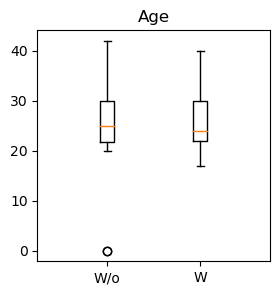

In [25]:
make_bv_plot(["age"], ["Age"], 1, 1, [[15, 55]], w = 3, h = 3, df0 = df_0_q, df1 = df_1_q)

### General task performance

In [26]:
compare(["num_correct"]) 
compare(["time_total", "time_alone", "time_ai"], df0 = df_0_q, df1 = df_1_q)

num_correct 

All
Mean: 6.567901234567901
Std: 1.7208831468348467
Min & Max: 3 10


Group 0
Mean: 6.097560975609756
Std: 1.6499058073451478
Min & Max: 3 10


Group 1
Mean: 7.05
Std: 1.6575584454250778
Min & Max: 4 10


Ttest_indResult(statistic=-2.7231750067833644, pvalue=0.009106059614573626)

---

time_total 

All
Mean: 295.7729451379914
Std: 193.26139932968428
Min & Max: 50.080055952072144 1077.3021922111511


Group 0
Mean: 218.0996164944437
Std: 97.77782659770146
Min & Max: 50.080055952072144 440.3612184524536


Group 1
Mean: 380.5074854764071
Std: 232.1727642313533
Min & Max: 138.51108479499817 1077.3021922111511


Ttest_indResult(statistic=-5.582831383972954, pvalue=1.2160385223122465e-06)

---

time_alone 

All
Mean: 98.44470831622247
Std: 96.7551778065496
Min & Max: 13.365952014923096 490.4555776119232


Group 0
Mean: 57.259311159451805
Std: 44.50866343816115
Min & Max: 13.365952014923096 210.50182175636292


Group 1
Mean: 143.37423248724505
Std: 116.37853662625054
Min & Max: 1

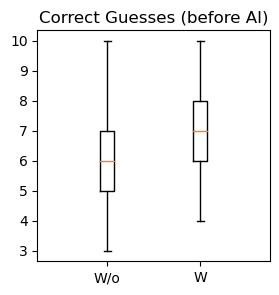

In [28]:
make_bv_plot(["num_correct"], ["Correct Guesses (before AI)"], 1, 1, [[-1, 11]], w = 3, h = 3)

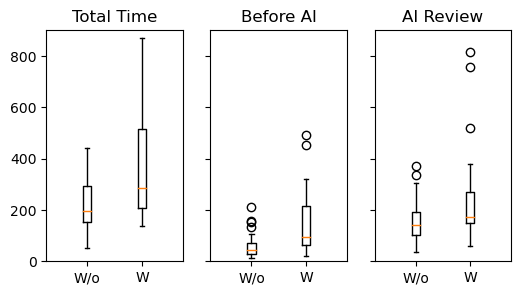

In [29]:
make_bv_plot(["time_total", "time_alone", "time_ai"], ["Total Time", "Before AI", "AI Review"], 1, 3, [[0, 900]], w = 6, h = 3, df0 = df_0_q, df1 = df_1_q)

## Misleading AI

In [26]:
df_1.columns

Index(['group', 'file', 'questionnaire', 'time_alone', 'time_ai', 'time_total',
       'AI_successful', 'euro_watcher', 'song_knowledge',
       'song_knowledge_which', 'AI_knowledge', 'AI_knowledge_what', 'age',
       'gender', 'AI_answer_basis', 'AI_plausibility', 'num_correct',
       'num_correct_ai', 'num_mislead', 'num_mislead_switch', 'num_incorrect',
       'num_help', 'num_help_switch', 'num_total_disagree', 'num_total_switch',
       'ratio_switch', 'ratio_help', 'ratio_mislead'],
      dtype='object')

In [29]:
compare(["ratio_switch", "ratio_help", "ratio_mislead"])

ratio_switch 

All
Mean: 0.0808641975308642
Std: 0.0808641975308642
Min & Max: 0.0 0.75


Group 0
Mean: 0.08292682926829269
Std: 0.08292682926829269
Min & Max: 0.0 0.5


Group 1
Mean: 0.07875000000000001
Std: 0.07875000000000001
Min & Max: 0.0 0.75


Ttest_indResult(statistic=0.3953708205292802, pvalue=0.69439687394222)

---

ratio_help 

All
Mean: 0.11187214611872145
Std: 0.11187214611872145
Min & Max: 0.0 1.0


Group 0
Mean: 0.10964912280701752
Std: 0.10964912280701752
Min & Max: 0.0 1.0


Group 1
Mean: 0.11428571428571428
Std: 0.11428571428571428
Min & Max: 0.0 1.0


Ttest_indResult(statistic=0.5494635640218044, pvalue=0.5853451818030939)

---

ratio_mislead 

All
Mean: 0.07818930041152262
Std: 0.07818930041152262
Min & Max: 0.0 0.75


Group 0
Mean: 0.08739837398373983
Std: 0.08739837398373983
Min & Max: 0.0 0.5


Group 1
Mean: 0.06875
Std: 0.06875
Min & Max: 0.0 0.75


Ttest_indResult(statistic=0.2224452245568836, pvalue=0.8249520446253221)

---



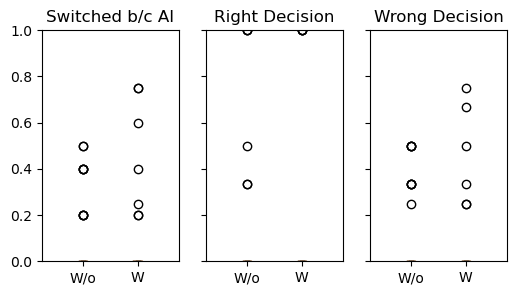

In [30]:
make_bv_plot(["ratio_switch", "ratio_help", "ratio_mislead"], ["Switched b/c AI", "Right Decision", "Wrong Decision"], 1, 3, [[0, 1]], w = 6, h = 3)

In [31]:
print(len(df_0), len(df_1))

print(len(df_0[df_0["num_total_switch"] != 0]))
print(len(df_1[df_1["num_total_switch"] != 0]))

print(len(df_0[df_0["num_mislead_switch"] != 0]))
print(len(df_1[df_1["num_mislead_switch"] != 0]))

print(len(df_0[df_0["num_help_switch"] != 0]))
print(len(df_1[df_1["num_help_switch"] != 0]))

41 40
10
7
9
6
6
4


In [32]:
df_0[["num_correct", "num_correct_ai"]]

,num_correct,num_correct_ai
0,6,6
1,4,4
2,6,6
3,3,3
4,9,9
5,4,3
6,6,8
7,6,6
8,7,7
9,4,3


In [33]:
df_1[["num_correct", "num_correct_ai"]]

,num_correct,num_correct_ai
41,7,7
42,7,7
43,5,5
44,10,10
45,8,8
46,5,6
47,8,8
48,4,4
49,5,5
50,6,5


num_correct 

All
Mean: 6.567901234567901
Std: 6.567901234567901
Min & Max: 3 10


Group 0
Mean: 6.097560975609756
Std: 6.097560975609756
Min & Max: 3 10


Group 1
Mean: 7.05
Std: 7.05
Min & Max: 4 10


Ttest_indResult(statistic=-2.7231750067833644, pvalue=0.009106059614573626)

---

num_correct_ai 

All
Mean: 6.493827160493828
Std: 6.493827160493828
Min & Max: 3 10


Group 0
Mean: 6.048780487804878
Std: 6.048780487804878
Min & Max: 3 10


Group 1
Mean: 6.95
Std: 6.95
Min & Max: 4 10


Ttest_indResult(statistic=-2.2912100223722653, pvalue=0.02658067321303936)

---



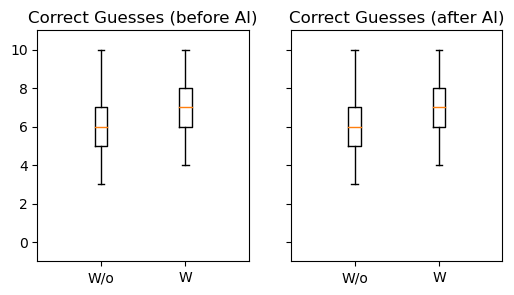

In [34]:
compare(["num_correct", "num_correct_ai"]) 
make_bv_plot(["num_correct", "num_correct_ai"], ["Correct Guesses (before AI)", "Correct Guesses (after AI)"], 1, 2, [[-1, 11]], w = 6, h = 3)

## What do people think?

In [27]:
df_data.columns

Index(['group', 'file', 'questionnaire', 'num_correct', 'num_correct_ai',
       'num_mislead', 'num_mislead_switch', 'num_incorrect', 'num_help',
       'num_help_switch', 'num_total_disagree', 'num_total_switch',
       'ratio_switch', 'ratio_help', 'ratio_mislead', 'time_alone', 'time_ai',
       'time_total', 'AI_successful', 'euro_watcher', 'song_knowledge',
       'song_knowledge_which', 'AI_knowledge', 'AI_knowledge_what', 'age',
       'gender', 'AI_answer_basis', 'AI_plausibility'],
      dtype='object')

In [28]:
compare(["AI_successful", "euro_watcher"], df0 = df_0_q, df1 = df_1_q)

AI_successful 

All
Mean: -0.13513513513513514
Std: -0.13513513513513514
Min & Max: -2.0 1.0


Group 0
Mean: 0.05263157894736842
Std: 0.05263157894736842
Min & Max: -1.0 1.0


Group 1
Mean: -0.3333333333333333
Std: -0.3333333333333333
Min & Max: -2.0 1.0


Ttest_indResult(statistic=0.4962368250971287, pvalue=0.6242417009316892)

---

euro_watcher 

All
Mean: 0.2702702702702703
Std: 0.2702702702702703
Min & Max: -2.0 2.0


Group 0
Mean: 0.47368421052631576
Std: 0.47368421052631576
Min & Max: -2.0 2.0


Group 1
Mean: 0.05555555555555555
Std: 0.05555555555555555
Min & Max: -2.0 2.0


Ttest_indResult(statistic=0.8503835616389483, pvalue=0.4035162579125585)

---



In [124]:
def count_likert(key):
    results = {}
    answers_0 = Counter(df_0_q[key])
    counts_0 = []
    answers_1 = Counter(df_1_q[key])
    counts_1 = []
    for i in range(-2,3):
        if i in answers_0:
            counts_0.append(answers_0[i])
        else:
            counts_0.append(0)
        if i in answers_1:
            counts_1.append(answers_1[i])
        else:
            counts_1.append(0)
    percs_0 = [c/sum(counts_0) for c in counts_0]
    percs_1 = [c/sum(counts_1) for c in counts_1]
    results["Group 0"] = percs_0
    results["Group 1"] = percs_1
    return results
    
def count_likert_trust(key):
    results = {}
    answers_0 = Counter(df_0_qt[key])
    counts_0 = []
    answers_1 = Counter(df_1_qt[key])
    counts_1 = []
    for i in range(-2,3):
        if i in answers_0:
            counts_0.append(answers_0[i])
        else:
            counts_0.append(0)
        if i in answers_1:
            counts_1.append(answers_1[i])
        else:
            counts_1.append(0)
    percs_0 = [c/sum(counts_0) for c in counts_0]
    percs_1 = [c/sum(counts_1) for c in counts_1]
    results["Group 0"] = percs_0
    results["Group 1"] = percs_1
    return results
    
results_ai = count_likert("AI_successful")
category_names_ai_reverse = ["VERY LIKELY", "LIKELY", "NEUTRAL", "UNLIKELY", "VERY UNLIKELY"]
category_names_ai = [category_names_ai_reverse[len(category_names_ai_reverse)-(i+1)] for i in range(len(category_names_ai_reverse))]
print(results_ai)
print(category_names_ai)

results_euro = count_likert("euro_watcher")
category_names_euro_reverse = ["EVERY YEAR", "MOST YEARS", "SOMETIMES", "RARELY", "NEVER"]
category_names_euro = [category_names_euro_reverse[len(category_names_euro_reverse)-(i+1)] for i in range(len(category_names_euro_reverse))]
print(results_euro)
print(category_names_euro)

{'Group 0': [0.0, 0.3611111111111111, 0.3055555555555556, 0.3055555555555556, 0.027777777777777776], 'Group 1': [0.09090909090909091, 0.42424242424242425, 0.15151515151515152, 0.3333333333333333, 0.0]}
['VERY UNLIKELY', 'UNLIKELY', 'NEUTRAL', 'LIKELY', 'VERY LIKELY']
{'Group 0': [0.1388888888888889, 0.3333333333333333, 0.16666666666666666, 0.1111111111111111, 0.25], 'Group 1': [0.18181818181818182, 0.30303030303030304, 0.21212121212121213, 0.09090909090909091, 0.21212121212121213]}
['NEVER', 'RARELY', 'SOMETIMES', 'MOST YEARS', 'EVERY YEAR']


[0.         0.09090909] [0. 0.]
[0.36111111 0.42424242] [0.         0.09090909]
[0.30555556 0.15151515] [0.36111111 0.51515152]
[0.30555556 0.33333333] [0.66666667 0.66666667]
[0.02777778 0.        ] [0.97222222 1.        ]


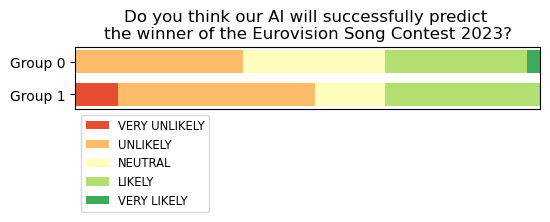

In [41]:
survey(results_ai, category_names_ai,"ai_success", "Do you think our AI will successfully predict \nthe winner of the Eurovision Song Contest 2023?", height = 0.8)

[0.13888889 0.18181818] [0. 0.]
[0.33333333 0.3030303 ] [0.13888889 0.18181818]
[0.16666667 0.21212121] [0.47222222 0.48484848]
[0.11111111 0.09090909] [0.63888889 0.6969697 ]
[0.25       0.21212121] [0.75       0.78787879]


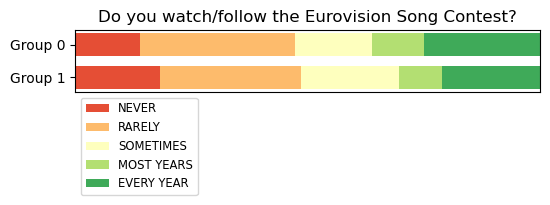

In [42]:
survey(results_euro, category_names_euro,"euro_watcher", "Do you watch/follow the Eurovision Song Contest?", height = 0.8)

In [43]:
ai_k_0 = list(Counter(df_0_q["AI_knowledge"]).values())
ai_k_0 = [ai_k_0[len(ai_k_0)-(i+1)] for i in range(len(ai_k_0))]
ai_k_1 = list(Counter(df_1_q["AI_knowledge"]).values())
ai_k_1 = [ai_k_1[len(ai_k_1)-(i+1)] for i in range(len(ai_k_1))]

so_k_0 = list(Counter(df_0_q["song_knowledge"]).values())
so_k_0 = [so_k_0[len(so_k_0)-(i+1)] for i in range(len(so_k_0))]
so_k_1 = list(Counter(df_1_q["song_knowledge"]).values())
so_k_1 = [so_k_1[len(so_k_1)-(i+1)] for i in range(len(so_k_1))]

results_AI_k = {"Group 0":[i/sum(ai_k_0) for i in ai_k_0], "Group 1":[i/sum(ai_k_1) for i in ai_k_1]}
results_song_k = {"Group 0":[i/sum(so_k_0) for i in so_k_0], "Group 1":[i/sum(so_k_1) for i in so_k_1]}

print(results_AI_k)
print(results_song_k)

Counter(df_0_q["song_knowledge"])

{'Group 0': [0.1111111111111111, 0.8888888888888888], 'Group 1': [0.7272727272727273, 0.2727272727272727]}
{'Group 0': [0.4166666666666667, 0.5833333333333334], 'Group 1': [0.6666666666666666, 0.3333333333333333]}


Counter({'NO': 21, 'YES': 15})

[0.11111111 0.72727273] [0. 0.]
[0.88888889 0.27272727] [0.11111111 0.72727273]


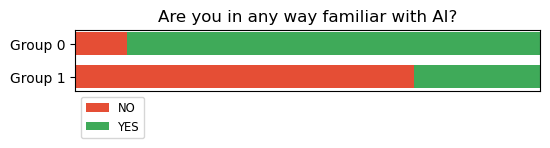

In [44]:
survey(results_AI_k, ["NO", "YES"], "ai_knowledge", "Are you in any way familiar with AI?", height = 0.8)

[0.41666667 0.66666667] [0. 0.]
[0.58333333 0.33333333] [0.41666667 0.66666667]


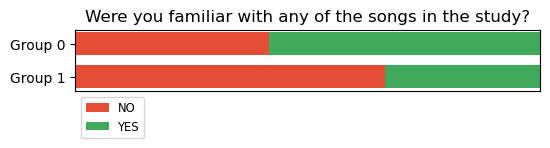

In [46]:
survey(results_song_k, ["NO", "YES"], "song_knowledge", "Were you familiar with any of the songs in the study?", height = 0.8)

In [47]:
df_0_q.columns

Index(['group', 'file', 'questionnaire', 'time_alone', 'time_ai', 'time_total',
       'AI_successful', 'euro_watcher', 'song_knowledge',
       'song_knowledge_which', 'AI_knowledge', 'AI_knowledge_what', 'age',
       'gender', 'AI_answer_basis', 'AI_plausibility', 'num_correct',
       'num_correct_ai', 'num_mislead', 'num_mislead_switch', 'num_incorrect',
       'num_help', 'num_help_switch', 'num_total_disagree', 'num_total_switch',
       'ratio_switch', 'ratio_help', 'ratio_mislead'],
      dtype='object')

In [48]:
df_qual = df_1_q
df_qual = df_qual.set_index("file")
print(len(df_qual))

33


In [49]:
AI_answer_basis = {
    '1_1.csv': ["data", "historical data"],
    '1_18.csv': ["data", "expert data"],
    '1_2.csv': ["lyrics", "lyrics resonate"],
    '1_3.csv': ["AI/ML"],
    '1_22.csv': ["data", "statistics"],
    '1_23.csv': ["lyrics"],
    '1_6.csv': ["data", "historical data"],
    '1_21.csv': ["lyrics", "lyrics resonate"],
    '1_20.csv': ["AI/ML"],
    '1_5.csv': ["lyrics"],
    '1_11.csv': ["lyrics"],
    '1_16.csv': ["country of singer"],
    '1_14.csv': ["lyrics"]
}

df_qual["AI_answer_basis_codes"] = pd.Series(AI_answer_basis)

AI_plausibility = {
    '1_1.csv': ["comparable to human"],
    '1_18.csv': ["plausible", "fairly plausible"],
    '1_2.csv': ["basis", "basis contradictory"],
    '1_3.csv': ["plausible", "very plausible"],
    '1_22.csv': ["comparable to human"],
    '1_23.csv': ["basis", "basis not sufficient"],
    '1_6.csv': ["plausible", "very plausible"],
    '1_21.csv': ["plausible", "somewhat plausible"],
    '1_20.csv': ["unsure"],
    '1_5.csv': ["plausible", "fairly plausible", "basis", "basis not sufficient"],
    '1_11.csv': ["not plausible", "basis", "basis not sufficient"],
    '1_16.csv': ["unsure"],
    '1_14.csv': ["plausible", "fairly plausible"]
}

df_qual["AI_plausibility_codes"] = pd.Series(AI_plausibility)

In [50]:
for i, row in df_qual.iterrows():
    print(i)
    print(row['num_mislead'],"-->", row['num_mislead_switch'])
    print(row['num_help'], "-->", row['num_help_switch'])
    print(row["AI_successful"])
    print("-",row["AI_answer_basis"], row["AI_answer_basis_codes"])
    print("-",row["AI_plausibility"], row["AI_plausibility_codes"])
    print("---")

1_0.csv
3 --> 0
1 --> 0
0.0
- nan nan
- nan nan
---
1_1.csv
3 --> 0
1 --> 0
1.0
- All past songs used in the ESC ['data', 'historical data']
- What an average person trying to convince me would say whether it's true or not ['comparable to human']
---
1_11.csv
5 --> 0
0 --> 0
-1.0
- As the explanations provided by the AI suggest, I believe the system only analyzes the lyrics of the songs, while the music is disregarded. ['lyrics']
- Not very plausible, as only one or maybe two lines of the lyrics were cited as basis of the decision ['not plausible', 'basis', 'basis not sufficient']
---
1_13.csv
2 --> 1
2 --> 2
-1.0
- nan nan
- nan nan
---
1_14.csv
4 --> 0
1 --> 0
-1.0
- mostly the lyrics ['lyrics']
- the explanations of the appeal of the lyrical contents are reasonable, but only considering lyrical content to predict the performance of a song is far too one-dimensional ['plausible', 'fairly plausible']
---
1_16.csv
2 --> 0
3 --> 0
0.0
- Scandinavian country, uplifting sound ['country of

In [51]:
plaus_codes = list(AI_plausibility.values())
plaus_codes = sum(plaus_codes, [])
print(set(plaus_codes))
plaus_codes = Counter(plaus_codes)
plaus_codes = sorted(list(plaus_codes.items()), key = lambda x: x[1], reverse = True)
for item in plaus_codes:
    print(item[0], ":", item[1])

{'basis not sufficient', 'plausible', 'basis contradictory', 'comparable to human', 'basis', 'somewhat plausible', 'not plausible', 'fairly plausible', 'very plausible', 'unsure'}
plausible : 6
basis : 4
fairly plausible : 3
basis not sufficient : 3
comparable to human : 2
very plausible : 2
unsure : 2
basis contradictory : 1
somewhat plausible : 1
not plausible : 1


[0 2 2 1 0] [0 0 0 0 0]
[2 0 0 0 3] [0 2 2 1 0]
[3 0 0 0 1] [2 2 2 1 3]
[1 0 0 0 0] [5 2 2 1 4]


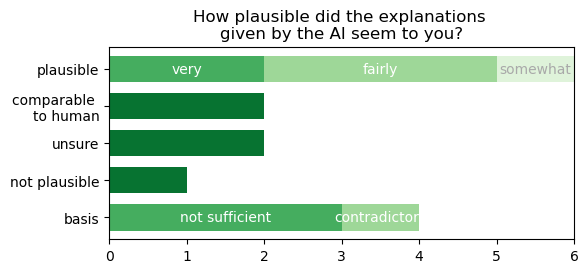

In [52]:
plaus_results = {
    "plausible": [0, 2, 3, 1],
    "comparable \nto human": [2, 0, 0, 0],
    "unsure": [2, 0, 0, 0],
    "not plausible": [1, 0, 0, 0],
    "basis": [0, 3, 1, 0]
}

plaus_bar_labels = [["", "very", "fairly", "somewhat"],
                    ["", "", "", ""],
                    ["", "", "", ""],
                    ["", "", "", ""],
                    ["", "not sufficient", "contradictory", ""]]
plaus_bar_labels = np.array(plaus_bar_labels)
plaus_bar_labels = plaus_bar_labels.T

survey(plaus_results, ["", "", "", ""], "plausible", "How plausible did the explanations \ngiven by the AI seem to you?", height = 2.5, legend = False, x_invisible = False, cmap = "Greens_r", use_bar_labels = True, bar_labels = plaus_bar_labels)



In [53]:
basis_codes = list(AI_answer_basis.values())
basis_codes = sum(basis_codes, [])
print(set(basis_codes))
basis_codes = Counter(basis_codes)
basis_codes = sorted(list(basis_codes.items()), key = lambda x: x[1], reverse = True)
for item in basis_codes:
    print(item[0], ":", item[1])

{'country of singer', 'expert data', 'AI/ML', 'lyrics', 'data', 'historical data', 'statistics', 'lyrics resonate'}
lyrics : 6
data : 4
historical data : 2
lyrics resonate : 2
AI/ML : 2
expert data : 1
statistics : 1
country of singer : 1


[4 1 0 2] [0 0 0 0]
[2 0 2 0] [4 1 0 2]
[0 0 1 0] [6 1 2 2]
[0 0 1 0] [6 1 3 2]


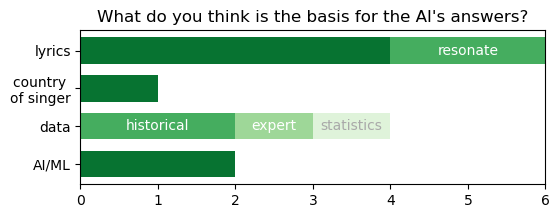

In [54]:
basis_results = {
    "lyrics": [4, 2, 0, 0],
    "country \nof singer": [1, 0, 0, 0],
    "data": [0, 2, 1, 1],
    "AI/ML": [2, 0, 0, 0]
}

basis_bar_labels = [["", "resonate", "", ""],
                    ["", "", "", ""],
                    ["", "historical", "expert", "statistics"],
                    ["", "", "", ""]
                   ]
basis_bar_labels = np.array(basis_bar_labels)
basis_bar_labels = basis_bar_labels.T

survey(basis_results, ["", "", "", ""], "basis", "What do you think is the basis for the AI\'s answers?", height = 2.0, legend = False, x_invisible = False, cmap = "Greens_r", use_bar_labels = True, bar_labels = basis_bar_labels)




### Trust Questionnaire Results ###

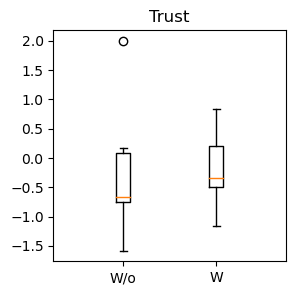

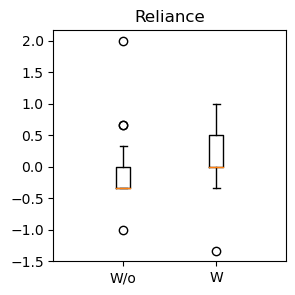

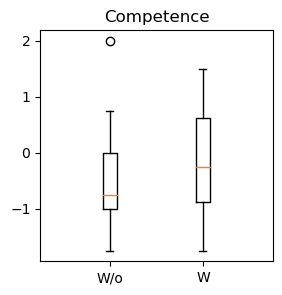

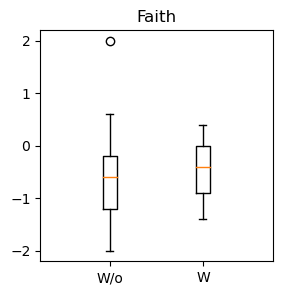

In [132]:
make_bv_plot(["trust"], ["Trust"], 1, 1, [[-2, +2]], w = 3, h = 3, df0 = df_0_qt, df1 = df_1_qt)

make_bv_plot(["rel"], ["Reliance"], 1, 1, [[-2, +2]], w = 3, h = 3, df0 = df_0_qt, df1 = df_1_qt)

make_bv_plot(["com"], ["Competence"], 1, 1, [[-2, +2]], w = 3, h = 3, df0 = df_0_qt, df1 = df_1_qt)
make_bv_plot(["fai"], ["Faith"], 1, 1, [[-2, +2]], w = 3, h = 3, df0 = df_0_qt, df1 = df_1_qt)


#print(category_names_euro)

category_names_trust_reverse = ["STRONGLY AGREE", "AGREE", "NEUTRAL", "DISAGREE", "STRONGLY DISAGREE"]
category_names_trust = [category_names_trust_reverse[len(category_names_trust_reverse)-(i+1)] for i in range(len(category_names_trust_reverse))]

#survey(results_trust, category_names_euro,"euro_watcher", "Results of modified HCT Questionnaire", height = 0.8)

#### Reliance

{'Group 0': [0.0, 0.16666666666666666, 0.6666666666666666, 0.0, 0.16666666666666666], 'Group 1': [0.0, 0.0, 0.875, 0.125, 0.0]}
[0.23529412 0.13333333] [0. 0.]
[0.41176471 0.4       ] [0.23529412 0.13333333]
[0.23529412 0.46666667] [0.64705882 0.53333333]
[0.05882353 0.        ] [0.88235294 1.        ]
[0.05882353 0.        ] [0.94117647 1.        ]
[0.05882353 0.06666667] [0. 0.]
[0.11764706 0.        ] [0.05882353 0.06666667]
[0.64705882 0.46666667] [0.17647059 0.06666667]
[0.11764706 0.46666667] [0.82352941 0.53333333]
[0.05882353 0.        ] [0.94117647 1.        ]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0.35294118 0.33333333] [0. 0.]
[0.58823529 0.6       ] [0.35294118 0.33333333]
[0.05882353 0.06666667] [0.94117647 0.93333333]


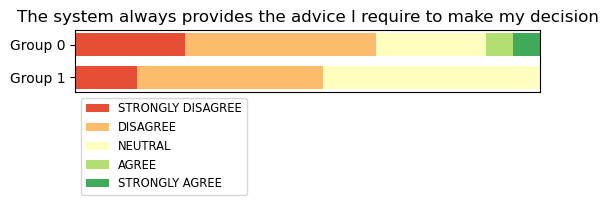

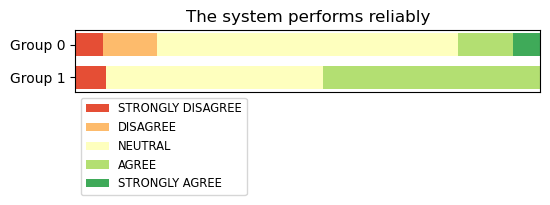

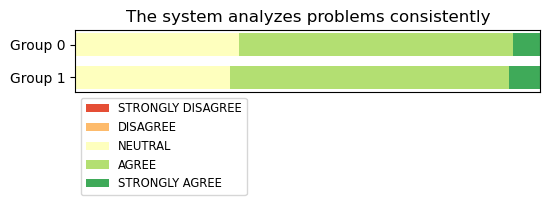

In [126]:
results_reliance = count_likert_trust("rel")
results_rel1 = count_likert_trust("rel_1")
results_rel2 = count_likert_trust("rel_2")
results_rel5 = count_likert_trust("rel_5")
print(results_reliance)

survey(results_rel1, category_names_trust,"rel_1", "The system always provides the advice I require to make my decision", height = 0.8)
survey(results_rel2, category_names_trust,"rel_2", "The system performs reliably", height = 0.8)
survey(results_rel5, category_names_trust,"rel_5", "The system analyzes problems consistently", height = 0.8)

[0.05882353 0.06666667] [0. 0.]
[0.05882353 0.33333333] [0.05882353 0.06666667]
[0.58823529 0.33333333] [0.11764706 0.4       ]
[0.23529412 0.26666667] [0.70588235 0.73333333]
[0.05882353 0.        ] [0.94117647 1.        ]
[0.11764706 0.06666667] [0. 0.]
[0.17647059 0.13333333] [0.11764706 0.06666667]
[0.52941176 0.46666667] [0.29411765 0.2       ]
[0.11764706 0.2       ] [0.82352941 0.66666667]
[0.05882353 0.13333333] [0.94117647 0.86666667]
[0.41176471 0.26666667] [0. 0.]
[0.35294118 0.13333333] [0.41176471 0.26666667]
[0.         0.33333333] [0.76470588 0.4       ]
[0.17647059 0.2       ] [0.76470588 0.73333333]
[0.05882353 0.06666667] [0.94117647 0.93333333]
[0.05882353 0.13333333] [0. 0.]
[0.05882353 0.26666667] [0.05882353 0.13333333]
[0.41176471 0.13333333] [0.11764706 0.4       ]
[0.41176471 0.13333333] [0.52941176 0.53333333]
[0.05882353 0.33333333] [0.94117647 0.66666667]


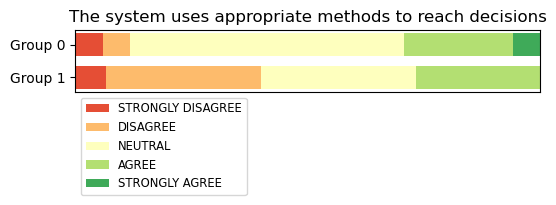

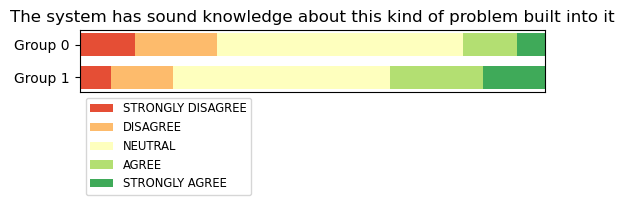

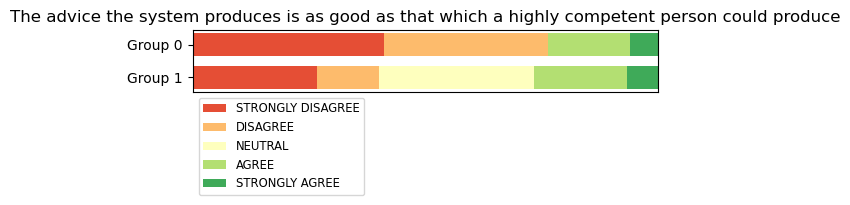

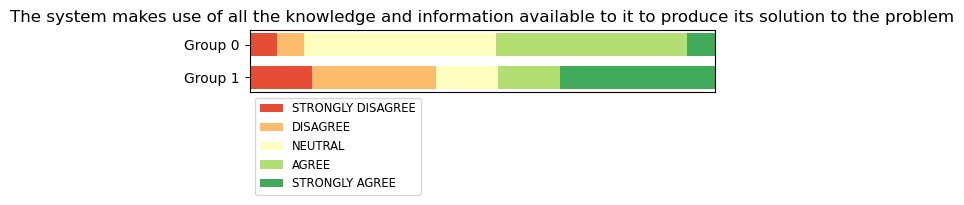

In [127]:
results_com = count_likert_trust("com")
results_com1 = count_likert_trust("com_1")
results_com2 = count_likert_trust("com_2")
results_com3 = count_likert_trust("com_3")
results_com5 = count_likert_trust("com_5")

survey(results_com1, category_names_trust,"com_1", "The system uses appropriate methods to reach decisions", height = 0.8)
survey(results_com2, category_names_trust,"com_2", "The system has sound knowledge about this kind of problem built into it", height = 0.8)
survey(results_com3, category_names_trust,"com_3", "The advice the system produces is as good as that which a highly competent person could produce", height = 0.8)
survey(results_com5, category_names_trust,"com_5", "The system makes use of all the knowledge and information available to it to produce its solution to the problem", height = 0.8)

[0.05882353 0.06666667] [0. 0.]
[0.58823529 0.4       ] [0.05882353 0.06666667]
[0.11764706 0.33333333] [0.64705882 0.46666667]
[0.17647059 0.2       ] [0.76470588 0.8       ]
[0.05882353 0.        ] [0.94117647 1.        ]
[0.29411765 0.2       ] [0. 0.]
[0.41176471 0.46666667] [0.29411765 0.2       ]
[0.  0.2] [0.70588235 0.66666667]
[0.23529412 0.06666667] [0.70588235 0.86666667]
[0.05882353 0.06666667] [0.94117647 0.93333333]
[0.23529412 0.2       ] [0. 0.]
[0.41176471 0.33333333] [0.23529412 0.2       ]
[0.23529412 0.26666667] [0.64705882 0.53333333]
[0.05882353 0.2       ] [0.88235294 0.8       ]
[0.05882353 0.        ] [0.94117647 1.        ]
[0.35294118 0.2       ] [0. 0.]
[0.41176471 0.26666667] [0.35294118 0.2       ]
[0.11764706 0.33333333] [0.76470588 0.46666667]
[0.05882353 0.2       ] [0.88235294 0.8       ]
[0.05882353 0.        ] [0.94117647 1.        ]
[0.23529412 0.06666667] [0. 0.]
[0.29411765 0.4       ] [0.23529412 0.06666667]
[0.17647059 0.4       ] [0.52941176 0.

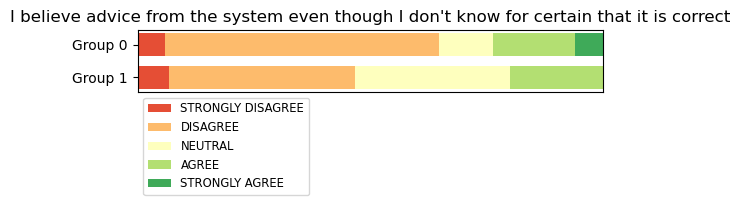

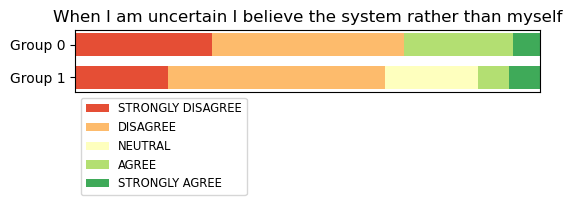

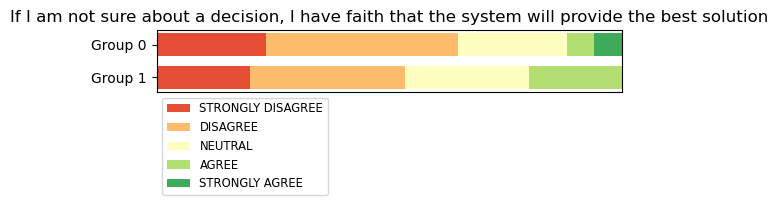

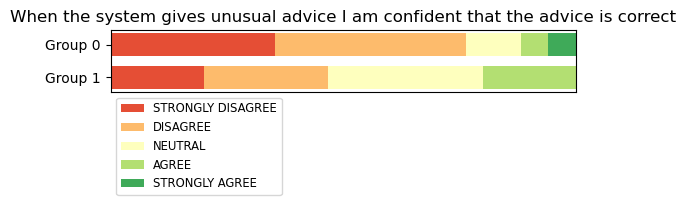

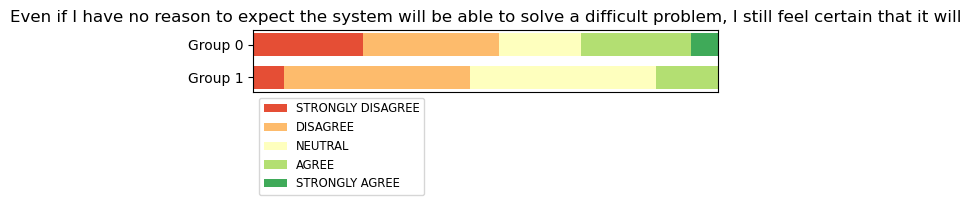

In [128]:
results_fai = count_likert_trust("fai")
results_fai1 = count_likert_trust("fai_1")
results_fai2 = count_likert_trust("fai_2")
results_fai3 = count_likert_trust("fai_3")
results_fai4 = count_likert_trust("fai_4")
results_fai5 = count_likert_trust("fai_5")

survey(results_fai1, category_names_trust,"fai_1", "I believe advice from the system even though I don't know for certain that it is correct", height = 0.8)
survey(results_fai2, category_names_trust,"fai_2", "When I am uncertain I believe the system rather than myself", height = 0.8)
survey(results_fai3, category_names_trust,"fai_3", "If I am not sure about a decision, I have faith that the system will provide the best solution", height = 0.8)
survey(results_fai4, category_names_trust,"fai_4", "When the system gives unusual advice I am confident that the advice is correct", height = 0.8)
survey(results_fai5, category_names_trust,"fai_5", "Even if I have no reason to expect the system will be able to solve a difficult problem, I still feel certain that it will", height = 0.8)

### Correlation between HCT result and misleads?

In [139]:
print(df_0_qt['trust'].corr(df_0_qt['num_mislead'], 'kendall'))
print(df_0_qt['rel'].corr(df_0_qt['num_mislead'], 'kendall'))
print(df_0_qt['fai'].corr(df_0_qt['num_mislead'], 'kendall'))
print(df_0_qt['com'].corr(df_0_qt['num_mislead'], 'kendall'))

-0.27582198676947545
-0.13560071180129693
-0.3706246583305506
-0.03843844537121786


In [140]:
print(df_1_qt['trust'].corr(df_1_qt['num_mislead'], 'kendall'))
print(df_1_qt['rel'].corr(df_1_qt['num_mislead'], 'kendall'))
print(df_1_qt['fai'].corr(df_1_qt['num_mislead'], 'kendall'))
print(df_1_qt['com'].corr(df_1_qt['num_mislead'], 'kendall'))

-0.11892969170906878
-0.44098104915550024
0.14488358652488856
-0.11892969170906878


Kendall's tau-B values:

    Less than + or - 0.10: very weak
    + or -0.10 to 0.19: weak
    + or - 0.20 to 0.29: moderate
    + or - 0.30 or above: strong
    
According to: https://www.researchgate.net/post/How-can-I-make-interpretation-of-kendalls-Tau-b-correlation-magnitude

We didn't find any rules of thumb for interpreting τb

as an effect size so we'll propose some:

    Tau-B = 0.07 indicates a weak association;
    
    Tau-B= 0.21 indicates a medium association;
    
    Tau-B= 0.35 indicates a strong association.

In [47]:
print("Group 0:")

tau, p_value = stats.kendalltau(df_0_qt['trust'], df_0_qt['num_mislead'])
print("Trust: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_0_qt['rel'], df_0_qt['num_mislead'])
print("Reliance: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_0_qt['fai'], df_0_qt['num_mislead'])
print("Faith: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_0_qt['com'], df_0_qt['num_mislead'])
print("Competence: Tau = " + str(tau) + ", p= " + str(p_value))


print("Group 1:")
tau, p_value = stats.kendalltau(df_1_qt['trust'], df_1_qt['num_mislead'])
print("Trust: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_1_qt['rel'], df_1_qt['num_mislead'])
print("Reliance: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_1_qt['fai'], df_1_qt['num_mislead'])
print("Faith: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_1_qt['com'], df_1_qt['num_mislead'])
print("Competence: Tau = " + str(tau) + ", p= " + str(p_value))

Group 0:
Trust: Tau = -0.27582198676947545, p= 0.17638454793923786
Reliance: Tau = -0.13560071180129693, p= 0.5343784680435557
Faith: Tau = -0.3706246583305506, p= 0.07106172248402891
Competence: Tau = -0.03843844537121786, p= 0.8541802475632307
Group 1:
Trust: Tau = -0.11892969170906878, p= 0.5823696629652255
Reliance: Tau = -0.44098104915550024, p= 0.055030896460805806
Faith: Tau = 0.14488358652488856, p= 0.5076505919011243
Competence: Tau = -0.11892969170906878, p= 0.5823696629652255


In [48]:
print("Group 0:")

tau, p_value = stats.kendalltau(df_0_qt['trust'], df_0_qt['num_total_switch'])
print("Trust: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_0_qt['rel'], df_0_qt['num_total_switch'])
print("Reliance: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_0_qt['fai'], df_0_qt['num_total_switch'])
print("Faith: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_0_qt['com'], df_0_qt['num_total_switch'])
print("Competence: Tau = " + str(tau) + ", p= " + str(p_value))


print("Group 1:")
tau, p_value = stats.kendalltau(df_1_qt['trust'], df_1_qt['num_total_switch'])
print("Trust: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_1_qt['rel'], df_1_qt['num_total_switch'])
print("Reliance: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_1_qt['fai'], df_1_qt['num_total_switch'])
print("Faith: Tau = " + str(tau) + ", p= " + str(p_value))

tau, p_value = stats.kendalltau(df_1_qt['com'], df_1_qt['num_total_switch'])
print("Competence: Tau = " + str(tau) + ", p= " + str(p_value))

Group 0:
Trust: Tau = -0.021926450482675733, p= 0.918357689171096
Reliance: Tau = -0.17413150828674812, p= 0.4472270966455748
Faith: Tau = 0.022097086912079608, p= 0.9182569383602482
Competence: Tau = -0.160422236979937, p= 0.4646543356904007
Group 1:
Trust: Tau = 0.3127259740659966, p= 0.1559820473385254
Reliance: Tau = 0.06388765649999399, p= 0.7851889044492887
Faith: Tau = 0.2453227608198226, p= 0.2711301595190334
Competence: Tau = 0.3127259740659966, p= 0.1559820473385254
